In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import itertools
import shutil
import random
import glob
import requests
import gzip
import math

from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
%matplotlib inline

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
path = 'vector_fashion'

def download_fmnist(path):
    DEFAULT_SOURCE_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = dict(
        TRAIN_IMAGES='train-images-idx3-ubyte.gz',
        TRAIN_LABELS='train-labels-idx1-ubyte.gz',
        TEST_IMAGES='t10k-images-idx3-ubyte.gz',
        TEST_LABELS='t10k-labels-idx1-ubyte.gz')
    if not os.path.exists(path):
        os.mkdir(path)
    for f in files:
        filepath = os.path.join(path, files[f])
        if not os.path.exists(filepath):
            url = DEFAULT_SOURCE_URL + files[f]
            r = requests.get(url, allow_redirects=True)

            open(filepath, 'wb').write(r.content)

            print('Successfully downloaded', f)
download_fmnist(path)

Successfully downloaded TRAIN_IMAGES
Successfully downloaded TRAIN_LABELS
Successfully downloaded TEST_IMAGES
Successfully downloaded TEST_LABELS


In [5]:
filePath_train_set = '/content/vector_fashion/train-images-idx3-ubyte.gz'
filePath_train_label = '/content/vector_fashion/train-labels-idx1-ubyte.gz'

filePath_test_set = '/content/vector_fashion/t10k-images-idx3-ubyte.gz'
filePath_test_label = '/content/vector_fashion/t10k-labels-idx1-ubyte.gz'

with gzip.open(filePath_train_label, 'rb') as trainLbpath:
     trainLabel = np.frombuffer(trainLbpath.read(), dtype=np.uint8,
                               offset=8)
with gzip.open(filePath_train_set, 'rb') as trainSetpath:
     trainSet = np.frombuffer(trainSetpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(trainLabel), 784)

with gzip.open(filePath_test_label, 'rb') as testLbpath:
     testLabel = np.frombuffer(testLbpath.read(), dtype=np.uint8,
                               offset=8)

with gzip.open(filePath_test_set, 'rb') as testSetpath:
     testSet = np.frombuffer(testSetpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(testLabel), 784)

print(type(testLabel))

print(trainSet.shape)

print(trainLabel.shape)

print(testSet.shape)

print(testLabel.shape)

<class 'numpy.ndarray'>
(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [6]:
val_split = False 
class_weight = None
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_x, test_x, train_y, test_y = trainSet, testSet, trainLabel, testLabel

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(class_labels)

train_x = train_x.reshape(60000, 28, 28, 1)/255
test_x = test_x.reshape(10000, 28, 28, 1)/255

print("NEW TRAIN DIM: ", train_x.shape)
print("NEW TEST DIM: ", test_x.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NEW TRAIN DIM:  (60000, 28, 28, 1)
NEW TEST DIM:  (10000, 28, 28, 1)


In [ ]:
'''

def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/vector_fashion/train-images-idx3-ubyte.gz", "/content/vector_fashion/train-labels-idx1-ubyte.gz",
        "fmnist_train.csv", 60000)
convert("/content/vector_fashion/t10k-images-idx3-ubyte.gz", "/content/vector_fashion/t10k-labels-idx1-ubyte.gz",
        "fmnist_test.csv", 10000)

'''


In [7]:
#preprocessing using ImageDatagenerator

image_gen = ImageDataGenerator(rotation_range=0,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5],
                               featurewise_center=False,
                               samplewise_center=False,
                               featurewise_std_normalization=False,
                               samplewise_std_normalization=False,
                               validation_split=0.2)

#image_gen.fit(train_x)

'''model.fit(datagen.flow(train_x, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(train_x, train_y,
         batch_size=8, subset='validation'),
         steps_per_epoch=len(x_train) / 32, epochs=epochs)'''




"model.fit(datagen.flow(train_x, y_train, batch_size=32,\n         subset='training'),\n         validation_data=datagen.flow(train_x, train_y,\n         batch_size=8, subset='validation'),\n         steps_per_epoch=len(x_train) / 32, epochs=epochs)"

In [8]:
def normalize(train_x, test_x):
#   train_x = train_x / 255
#   test_x = test_x / 255
  mu = np.mean(train_x, axis=0)
  std = np.std(train_x, axis=0)
  train = (train_x - mu) / std
  test = (test_x - mu) / std
  return train_x, test_x


def expand_data(x, y, factor=2):
  for i, (x_batch, y_batch) in enumerate(img_gen.flow(x, y, batch_size=len(x))):
    if i >= factor - 1:
      break
    x, y = np.concatenate((x, x_batch)), np.concatenate((y, y_batch))
  return x, y

def get_class_weight(y):
  class_freq = Counter(y)
  return {label: math.log(len(y) / class_freq[label]) for label in range(len(class_labels))}


def even_out_dist(x, y, max_freq=None):
  class_freq = Counter(y)
  if max_freq is None:
    max_freq = max(class_freq.values())
  class_data = [[] for i in range(len(class_labels))]
  for i, label in enumerate(y):
    class_data[label].append(x[i])
  for c in range(len(class_labels)):
    if max_freq < class_freq[c]:
      raise ValueError("max_freq must be greater than any class frequency")
    print('Expanding class {} from {} to {}'.format(c, class_freq[c], max_freq))
    num = len(class_data[c])
    for x_batch in image_gen.flow(np.array(class_data[c]), batch_size=class_freq[c], shuffle=True):
      num += len(x_batch)
      if num >= max_freq:
        if num - len(x_batch) < max_freq:
          x = np.concatenate((x, x_batch[:max_freq - (num - len(x_batch))]))
          y = np.append(y, [c]*(max_freq - (num - len(x_batch))))
        break
      x, y = np.concatenate((x, x_batch)), np.append(y, [c]*len(x_batch))
  return x, y


if val_split:
  train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
class_weight = get_class_weight(train_y)
print('class weight:')


train_x, train_y = even_out_dist(train_x, train_y, max_freq=40000)
# train_x, train_y = expand_data(train_x, train_y, factor=2)
print('training data size:', train_x.shape[0])
if val_split:
  print('validation data size:', val_x.shape[0])


class weight:
Expanding class 0 from 6000 to 40000
Expanding class 1 from 6000 to 40000
Expanding class 2 from 6000 to 40000
Expanding class 3 from 6000 to 40000
Expanding class 4 from 6000 to 40000
Expanding class 5 from 6000 to 40000
Expanding class 6 from 6000 to 40000
Expanding class 7 from 6000 to 40000
Expanding class 8 from 6000 to 40000
Expanding class 9 from 6000 to 40000
training data size: 400000


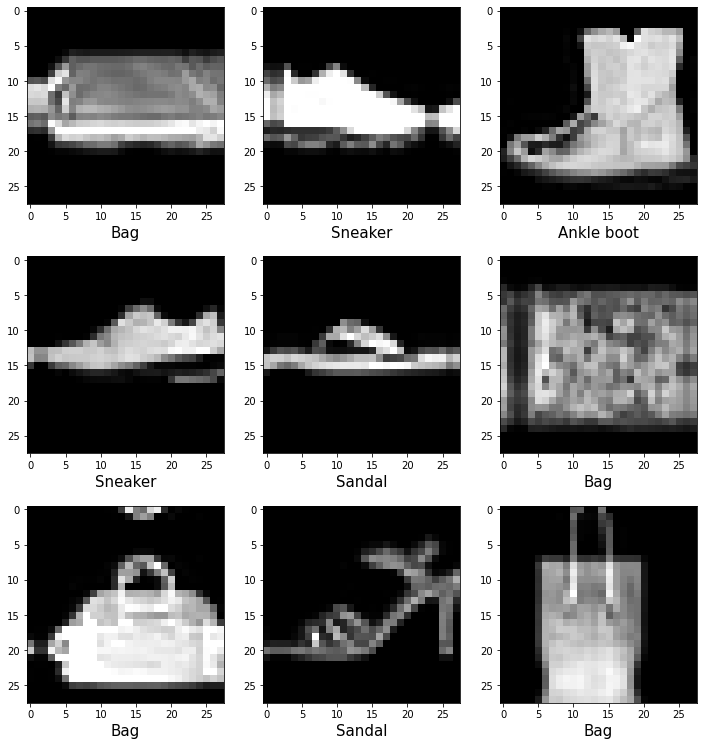

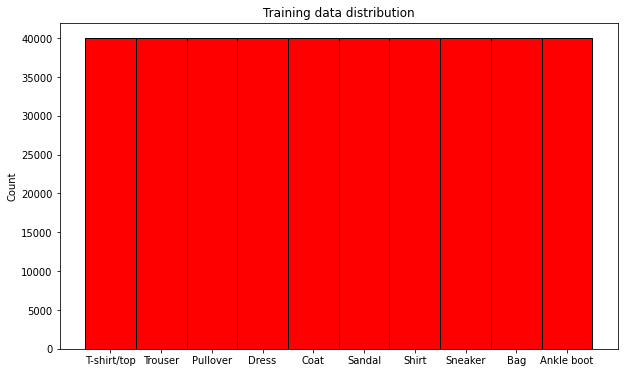

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(12, 13))
for row in axes:
  for axis in row:
    rand_idx = random.randrange(len(train_x))
    axis.set_xlabel(class_labels[train_y[rand_idx]], fontsize=15)
    axis.imshow(train_x[rand_idx].reshape(28, 28), cmap='gray')

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.hist(train_y, bins=np.arange(11) - 0.5, facecolor='red', edgecolor='black')
plt.xticks(np.arange(10), [class_labels[i] for i in range(10)])
plt.ylabel('Count')
plt.title("Training data distribution")
plt.show()

In [10]:
train_y = tf.keras.utils.to_categorical(train_y, num_classes=len(class_labels))
if val_split:
  val_y = tf.keras.utils.to_categorical(val_y, num_classes=len(class_labels))

In [11]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
model_name = 'vec-fmnist_cnn.h5'
model_path = os.path.join(save_dir, model_name)

model = Sequential()

model.add(BatchNormalization(input_shape=train_x.shape[1:]))
model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=None, input_shape=(1,28,28)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, kernel_regularizer=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(512, kernel_regularizer=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.99, beta_2=0.9999, decay=1e-8),
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       409728    
                                                                 
 activation_1 (Activation)   (None, 28, 28, 128)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cb = [ReduceLROnPlateau(monitor='acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)]

val_cb = [
    ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=0.00001),
    # EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True),
]

if val_split:
  hist = model.fit(train_x, train_y, batch_size=128*8, epochs=100, class_weight=class_weight, validation_data=(val_x, val_y), callbacks=val_cb, verbose=1)
  scores = model.evaluate(val_x, val_y)
  print('loss:', scores[0])
  print('accuracy:', scores[1])
else:
  hist = model.fit(train_x, train_y, batch_size=128*8, epochs=100, class_weight=class_weight, callbacks=cb, verbose=1)

Epoch 1/100
391/391 [==============================] - 282s 614ms/step - loss: 1.8206 - accuracy: 0.7044 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 234s 599ms/step - loss: 1.1260 - accuracy: 0.8149 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 233s 596ms/step - loss: 0.9233 - accuracy: 0.8476 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 233s 595ms/step - loss: 0.8174 - accuracy: 0.8656 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 233s 597ms/step - loss: 0.7253 - accuracy: 0.8814 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 233s 596ms/step - loss: 0.6589 - accuracy: 0.8926 - lr: 0.0010
Epoch 7/100
391/391 [==============================] - 233s 596ms/step - loss: 0.6179 - accuracy: 0.8994 - lr: 0.0010
Epoch 8/100
391/391 [==============================] - 233s 595ms/step - loss: 0.6248 - accuracy: 0.8977 - lr: 0.0010
Epoch 9/100
391/391 [==============================] - 2

In [ ]:
legend = ['Train']
plt.plot(hist.history['acc'])
if val_split:
  plt.plot(hist.history['val_acc'])
  legend.append('Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train']
plt.plot(hist.history['loss'])
if val_split:
  plt.plot(hist.history['val_loss'])
  legend.append('Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

In [ ]:
def load_sample_images(size):
  imgs = [cv2.imread(test_x, str(random.randrange(10000)) + '.png'), 0).reshape(28, 28, 1) for i in range(size)]
  return np.array(imgs, dtype='float32')

samples = load_sample_images(16)
out_layers = model.predict(samples, batch_size=8, verbose=1)
predictions = [np.argmax(layer) for layer in out_layers]

fig, axes = plt.subplots(4, 4, figsize=(16, 17))
i = 0
for row in axes:
  for axis in row:
    axis.set_xlabel('prediction: ' + classes[predictions[i]], fontsize=12)
    axis.imshow(samples[i].reshape(28, 28), cmap='gray')
    i += 1

predictions = model.predict(test_x)
print(predictions.shape)

In [ ]:
predictions1D = np.zeros(10000,dtype=np.int16)
for row_i in range(len(predictions)):
    predictions1D[row_i] = np.argmax(predictions[row_i])

print(predictions1D)


conf_matrix = np.zeros((10,10),dtype=np.int16)
for i in range(len(predictions1D)):

    p_class = predictions1D[i]
    t_class = test_y[i]
    conf_matrix[t_class][p_class] = conf_matrix[t_class][p_class] + 1


In [ ]:
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(conf_matrix[i, j]),
            horizontalalignment="center",
            color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()